In [1]:
import os
import csv
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly

import nltk

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
#from nltk.stem import PorterStemmer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from wordcloud import WordCloud

# Data Gathering

In [2]:
from google.colab import drive  
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/My Drive/NLP'
!ls -la

/content/drive/My Drive/NLP
total 146087
drwx------ 2 root root      4096 Feb 12 11:42 data
-rw------- 1 root root    627935 Mar  7 13:08 FNC.ipynb
-rw------- 1 root root 148960239 Mar  7 09:49 train_df.csv


In [4]:
def fnc(path_headlines, path_bodies):

    map = {'agree': 0, 'disagree':1, 'discuss':2, 'unrelated':3}

    with open(path_bodies, encoding='utf_8') as fb:  # Body ID,articleBody
        body_dict = {}
        lines_b = csv.reader(fb)
        for i, line in enumerate(tqdm(list(lines_b), ncols=80, leave=False)):
            if i > 0:
                body_id = int(line[0].strip())
                body_dict[body_id] = line[1]

    with open(path_headlines, encoding='utf_8') as fh: # Headline,Body ID,Stance
        lines_h = csv.reader(fh)
        h = []
        b = []
        l = []
        for i, line in enumerate(tqdm(list(lines_h), ncols=80, leave=False)):
            if i > 0:
                body_id = int(line[1].strip())
                label = line[2].strip()
                if label in map and body_id in body_dict:
                    h.append(line[0])
                    l.append(map[line[2]])
                    b.append(body_dict[body_id])
    return h, b, l

data_dir = './data'
headlines, bodies, labels = fnc(
    os.path.join(data_dir, 'combined_stances_train.csv'),
    os.path.join(data_dir, 'combined_bodies_train.csv')
)

list_of_tuples = list(zip(headlines, bodies, labels))
df = pd.DataFrame(list_of_tuples, columns=['text_a', 'text_b', 'label'])
train_df, val_df = train_test_split(df)
labels_val = pd.Series(val_df['label']).to_numpy()

headlines, bodies, labels = fnc(
    os.path.join(data_dir, 'combined_stances_test.csv'),
    os.path.join(data_dir, 'combined_bodies_test.csv')
)

list_of_tuples = list(zip(headlines, bodies, labels))
test_df = pd.DataFrame(list_of_tuples, columns=['text_a', 'text_b', 'label'])
labels_test = pd.Series(test_df['label']).to_numpy()

# Data Exploratory Analysis (Visualisation) 📊

In [6]:
train_df

,text_a,text_b,label
44923,ISIL Beheads American Photojournalist in Iraq,"According to multiple reports, ISIS claims to ...",2
34484,HORROR: ISIS Fighters Have Reportedly Contract...,The World Health Organization is looking into ...,2
46800,WHO investigates media reports ISIS fighters c...,The Islamic State (Isis) operating in Iraq doe...,2
5986,Insurgents killed in Nigeria despite alleged t...,At least 25 suspected Boko Haram insurgents we...,2
16486,‘Feminist’ says she aborted baby because it wa...,"On Tuesday, Apple unveiled its first wearable ...",3
...,...,...,...
29896,YPG Confirms: Gill Rosenberg Not Captured in K...,Absolutely awful news. Media are reporting tha...,3
62519,Overcrowding is a legitimate threat,It is an unassailable fact that race-based aff...,3
7958,Mexican students not among bodies found in mas...,"CHILPANCINGO, Mexico (AP) — Authorities testin...",0
25313,Jihadi John UNMASKED: Islamic State killer NAM...,At least not anytime soon\n\nThe internet has ...,3


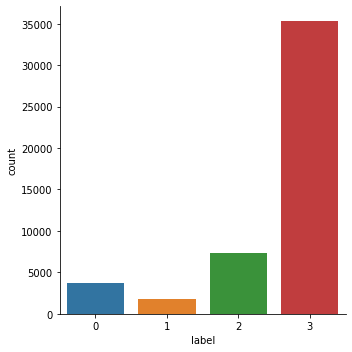

In [ ]:
sns.catplot('label', data=train_df, kind='count')

In [ ]:
labels = ['0',' 1','2','3']
values = [
      len(train_df[(train_df["label"] == 0)]), 
      len(train_df[(train_df["label"] == 1)]), 
      len(train_df[(train_df["label"] == 2)]), 
      len(train_df[(train_df["label"] == 3)]), 
]
colors = ['#FEBFBB', '#E13966']

trace = go.Pie(labels=labels, values=values,
               hoverinfo='label+percent', textinfo='value', 
               textfont=dict(size=20),
               marker=dict(colors=colors, 
                           line=dict(color='#000000', width=2)))

plotly.offline.iplot([trace], filename='styled_pie_chart')

(-0.5, 399.5, 199.5, -0.5)

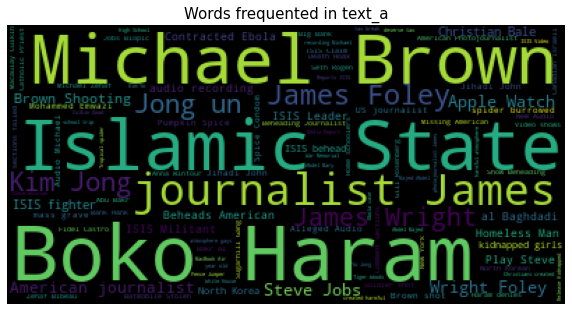

In [ ]:
cloud = train_df.text_a.tolist()
cloud_st = " ".join(cloud)
plt.figure(figsize=(10,10))
plt.title("Words frequented in text_a", fontsize=15)
plt.imshow(WordCloud().generate(cloud_st))
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

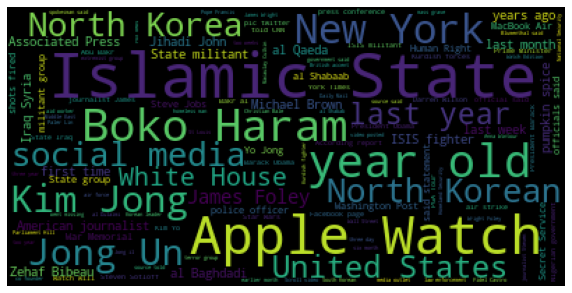

In [ ]:
cloud = train_df.text_b.tolist()
cloud_st = " ".join(cloud)
plt.title("Words frequented in text_b", fontsize=15)
plt.figure(figsize=(10,10))
plt.imshow(WordCloud().generate(cloud_st))
plt.axis("off")

# Data Prepossessing

In [7]:
train_df.isnull().sum()

text_a    0
text_b    0
label     0
dtype: int64

In [5]:
train_df['content'] = train_df['text_a']+' '+train_df['text_b']

Split the label we want to predict

In [9]:
X= train_df.drop(columns='label', axis=1)
Y = train_df['label']
X.shape

(48153, 3)

### STEMMING:

A stemming algorithm is a process of linguistic normalisation, in which the variant forms of a word are reduced to a common form.
In simple words, Stemming is the process of reducing a word to its Root word.

In [10]:
nltk.download('stopwords')
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
def stemming(content):
    rev = re.sub('[^a-zA-Z]',' ',content)
    rev = rev.lower()
    rev = rev.split()
    rev = [ps.stem(word) for word in rev if not word in stopwords.words('english')]
    rev = ' '.join(rev)
    return rev

In [17]:
train_df['content'] = train_df['content'].apply(stemming)
train_df

,text_a,text_b,label,content
44923,ISIL Beheads American Photojournalist in Iraq,"According to multiple reports, ISIS claims to ...",2,isil behead american photojournalist iraq acco...
34484,HORROR: ISIS Fighters Have Reportedly Contract...,The World Health Organization is looking into ...,2,horror isi fighter reportedli contract ebola w...
46800,WHO investigates media reports ISIS fighters c...,The Islamic State (Isis) operating in Iraq doe...,2,investig media report isi fighter contract ebo...
5986,Insurgents killed in Nigeria despite alleged t...,At least 25 suspected Boko Haram insurgents we...,2,insurg kill nigeria despit alleg truce boko ha...
16486,‘Feminist’ says she aborted baby because it wa...,"On Tuesday, Apple unveiled its first wearable ...",3,feminist say abort babi boy tuesday appl unvei...
...,...,...,...,...
29896,YPG Confirms: Gill Rosenberg Not Captured in K...,Absolutely awful news. Media are reporting tha...,3,ypg confirm gill rosenberg captur kobani absol...
62519,Overcrowding is a legitimate threat,It is an unassailable fact that race-based aff...,3,overcrowd legitim threat unassail fact race ba...
7958,Mexican students not among bodies found in mas...,"CHILPANCINGO, Mexico (AP) — Authorities testin...",0,mexican student among bodi found mass grave ch...
25313,Jihadi John UNMASKED: Islamic State killer NAM...,At least not anytime soon\n\nThe internet has ...,3,jihadi john unmask islam state killer name wes...


In [6]:
train_df=pd.read_csv('train_df.csv')

separating the data and label

In [7]:
X = train_df['content'].values
Y = train_df['label'].values

In [8]:
X.shape

(48153,)

# ML models

## Baseline ML/DL

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from tensorflow.keras.utils import to_categorical


TF-IDF stands for “Term Frequency – Inverse Document Frequency ”

In [10]:
# converting the textual data to numerical data
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X_tfidf = vectorizer.transform(X)
X_tfidf

<48153x20672 sparse matrix of type '<class 'numpy.float64'>'
	with 5912910 stored elements in Compressed Sparse Row format>

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf,Y, test_size=0.2)

In [30]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [12]:
def accuracy_model(model):
  # accuracy score on the training data
  X_train_prediction = model.predict(X_train)
  training_data_accuracy = accuracy_score(X_train_prediction, y_train)
  print('Accuracy score of the training data : %0.3f'%training_data_accuracy)

  print('-------------------------------------------')


  # accuracy score on the test data
  X_test_prediction = model.predict(X_test)
  test_data_accuracy = accuracy_score(X_test_prediction, y_test)
  print('Accuracy score of the test data : %0.3f'%test_data_accuracy)


### LOGISTIC REGRESSION

In [ ]:
from sklearn.model_selection import GridSearchCV
logreg = LogisticRegression()
max_iter = [100, 200, 500, 1000]
C = [0.1, 0.5, 1, 10, 50, 100]

param_grid = dict(max_iter=max_iter, C=C)

grid = GridSearchCV(estimator=logreg,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=2)

grid_result = grid.fit(X_train, y_train)
print('Best params: ', grid_result.best_params_)

logreg = grid_result.best_estimator_


logreg.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ................................C=0.1, max_iter=100; total time=  13.2s
[CV] END ................................C=0.1, max_iter=100; total time=  10.8s
[CV] END ................................C=0.1, max_iter=100; total time=  10.9s
[CV] END ................................C=0.1, max_iter=100; total time=  10.9s
[CV] END ................................C=0.1, max_iter=100; total time=  12.6s
[CV] END ................................C=0.1, max_iter=200; total time=  10.7s
[CV] END ................................C=0.1, max_iter=200; total time=  10.9s
[CV] END ................................C=0.1, max_iter=200; total time=  10.6s
[CV] END ................................C=0.1, max_iter=200; total time=  11.2s
[CV] END ................................C=0.1, max_iter=200; total time=  12.7s
[CV] END ................................C=0.1, max_iter=500; total time=  10.9s
[CV] END ................................C=0.1,

LogisticRegression(C=0.1)

In [ ]:
accuracy_model(logreg)

Accuracy score of the training data : 0.798
-------------------------------------------
Accuracy score of the test data : 0.789


In [ ]:
#Confusion Matrix 
y_pred_logreg = logreg.predict(X_test)
cm_log = confusion_matrix(y_test, y_pred_logreg)
cm_log

array([[  79,    9,   54,  578],
       [   6,    8,   12,  318],
       [  18,    3,  567,  925],
       [   6,    3,   98, 6947]])

Text(69.0, 0.5, 'Truth')

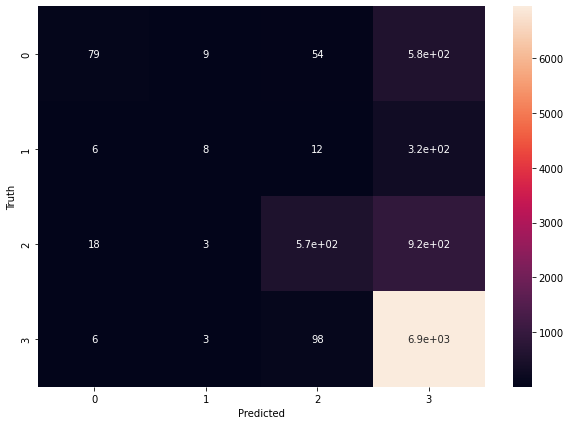

In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(cm_log, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

### DECISION TREE CLASSIFIER

In [32]:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [33]:
accuracy_model(tree)

Accuracy score of the training data : 1.000
-------------------------------------------
Accuracy score of the test data : 0.856


In [ ]:
#Confusion Matrix 
y_pred_tree=tree.predict(X_test)
cm_tree = confusion_matrix(y_test, y_pred_tree)
cm_tree

array([[ 358,   71,  116,  175],
       [  51,  104,   29,  160],
       [ 111,   48, 1096,  258],
       [ 142,  133,  153, 6626]])

Text(69.0, 0.5, 'Truth')

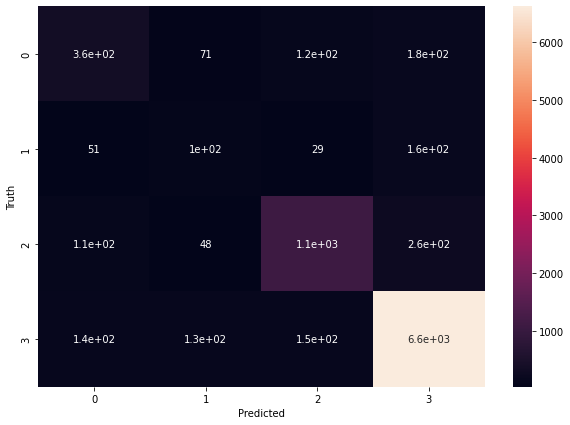

In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(cm_tree, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

### GRADIENT BOOSTING CLASSIFIER

In [ ]:
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

In [ ]:
accuracy_model(gbrt)

Accuracy score of the training data : 0.795
-------------------------------------------
Accuracy score of the test data : 0.790


In [ ]:
#Confusion Matrix 
y_pred_gbrt=gbrt.predict(X_test)
cm_gbrt = confusion_matrix(y_test, y_pred_gbrt)
cm_gbrt

array([[  72,   10,   41,  597],
       [   4,   22,    5,  313],
       [   8,    7,  487, 1011],
       [   1,    2,   24, 7027]])

Text(69.0, 0.5, 'Truth')

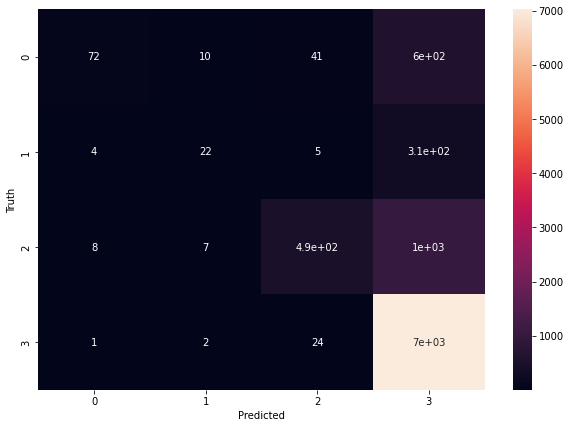

In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(cm_gbrt, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

### LINEAR SVM

In [ ]:
linear_svm = LinearSVC()
linear_svm.fit(X_train, y_train)

LinearSVC()

In [ ]:
accuracy_model(linear_svm)

Accuracy score of the training data : 0.832
-------------------------------------------
Accuracy score of the test data : 0.788


In [ ]:
#Confusion Matrix 
y_pred_svm = linear_svm.predict(X_test)
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_svm

array([[ 171,   16,   53,  480],
       [  28,   17,   14,  285],
       [  35,    3,  672,  803],
       [  79,   79,  166, 6730]])

Text(69.0, 0.5, 'Truth')

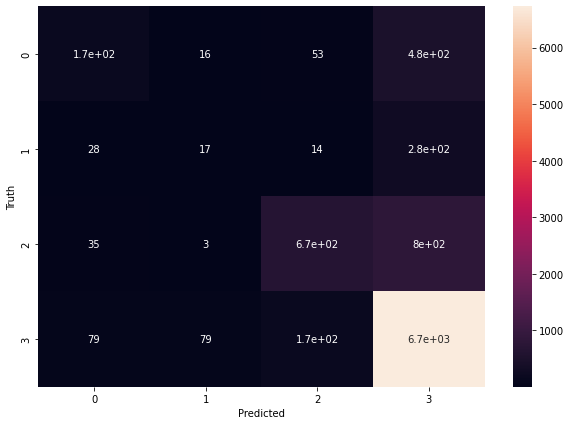

In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(cm_svm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

### Multinomial Naive Bayes

In [ ]:
m_nb=MultinomialNB()
m_nb.fit(X_train, y_train)

MultinomialNB()

In [ ]:
accuracy_model(m_nb)

Accuracy score of the training data : 0.752
-------------------------------------------
Accuracy score of the test data : 0.751


In [ ]:
#Confusion Matrix 
y_pred_nb = m_nb.predict(X_test)
cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_nb

array([[  16,    1,   60,  643],
       [   1,    0,   15,  328],
       [   4,    0,  553,  956],
       [   7,    2,  383, 6662]])

Text(69.0, 0.5, 'Truth')

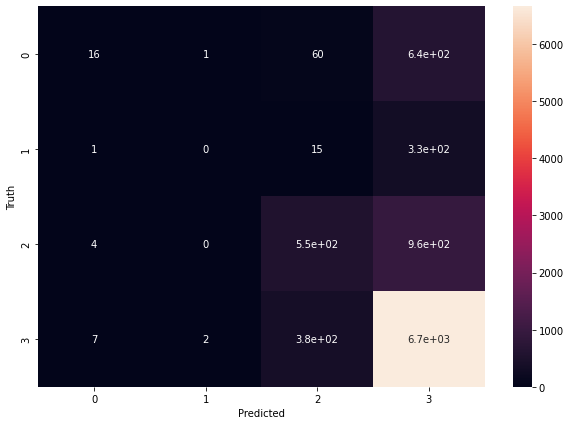

In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(cm_nb, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

## MLP

In [34]:
from sklearn.neural_network import MLPClassifier

mlp_arch={'64_64':(64,64),
          '32_64_128':(32,64,128),
          '128_64_48_32':(128,64,48,32)}

_mlp=[MLPClassifier(hidden_layer_sizes=arch,random_state=1) for _,arch in mlp_arch.items()]          

In [35]:
_mlp[0].fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=(64, 64), random_state=1)

## Seq2Seq

In [13]:
import tensorflow as tf 

In [18]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

In [19]:
tok = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS) 
tok.fit_on_texts(list(train_df['content'])) 

In [20]:
print(len(tok.word_index))
vocab_size = len(tok.word_index) + 1

20691


In [21]:
content_df = tok.texts_to_sequences(list(train_df['content'])) #this is how we create sequences
content_df = tf.keras.preprocessing.sequence.pad_sequences(content_df, maxlen=MAX_SEQUENCE_LENGTH) 

In [22]:
X_train, X_test, y_train, y_test = train_test_split(content_df, Y, test_size=0.1, random_state=1)

In [23]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [56]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(tf.keras.layers.SpatialDropout1D(0.2))
model.add(tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(tf.keras.layers.Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          500000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 4)                 404       
                                                                 
Total params: 580,804
Trainable params: 580,804
Non-trainable params: 0
_________________________________________________________________


In [58]:
epochs = 5
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
610/610 [==============================] - 618s 1s/step - loss: 0.7406 - accuracy: 0.7539 - val_loss: 0.6908 - val_accuracy: 0.7623
Epoch 2/5
610/610 [==============================] - 579s 949ms/step - loss: 0.6175 - accuracy: 0.7849 - val_loss: 0.6397 - val_accuracy: 0.7762
Epoch 3/5
610/610 [==============================] - 576s 944ms/step - loss: 0.5763 - accuracy: 0.7950 - val_loss: 0.6301 - val_accuracy: 0.7854
Epoch 4/5
610/610 [==============================] - 577s 946ms/step - loss: 0.5540 - accuracy: 0.7982 - val_loss: 0.6355 - val_accuracy: 0.7845
Epoch 5/5
610/610 [==============================] - 576s 944ms/step - loss: 0.5354 - accuracy: 0.8022 - val_loss: 0.6404 - val_accuracy: 0.7815


In [59]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

151/151 [==============================] - 10s 63ms/step - loss: 0.6162 - accuracy: 0.7936
Test set
  Loss: 0.616
  Accuracy: 0.794


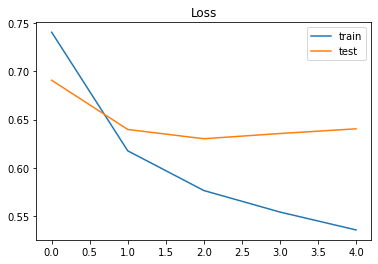

In [60]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()